Agents on Pareto frontier:
Agent(cost=5.98±0.40, acc=8.01±0.36)
Agent(cost=1.80±0.26, acc=2.04±0.37)


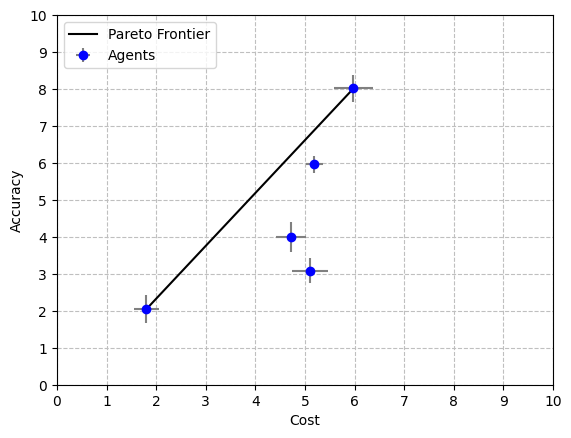

In [23]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from dataclasses import dataclass

GRID_WIDTH = 10
GRID_HEIGHT = 10
AGENT_NR = 5  # Number of points

@dataclass
class Agent:
    cost_measurements: list
    acc_measurements: list

    @property
    def cost_mean(self):
        return np.mean(self.cost_measurements)

    @property
    def acc_mean(self):
        return np.mean(self.acc_measurements)

    @property
    def cost_conf_interval(self):
        if len(self.cost_measurements) > 1:
            return stats.sem(self.cost_measurements) * stats.t.ppf((1 + 0.95) / 2., len(self.cost_measurements)-1)
        else:
            return 0

    @property
    def acc_conf_interval(self):
        if len(self.acc_measurements) > 1:
            return stats.sem(self.acc_measurements) * stats.t.ppf((1 + 0.95) / 2., len(self.acc_measurements)-1)
        else:
            return 0

    def __repr__(self):
        return f"Agent(cost={self.cost_mean:.2f}±{self.cost_conf_interval:.2f}, acc={self.acc_mean:.2f}±{self.acc_conf_interval:.2f})"

def generate_agent() -> Agent:
    cost_mean = random.randint(2, GRID_WIDTH-2)
    acc_mean = random.randint(2, GRID_HEIGHT-2)
    x_samples = [random.gauss(cost_mean, 0.5) for _ in range(10)]  # Gaussian distributed x
    y_samples = [random.gauss(acc_mean, 0.5) for _ in range(10)]  # Gaussian distributed y
    return Agent(x_samples, y_samples)

def draw_grid() -> None:
    plt.axis([-1, GRID_WIDTH + 1, -1, GRID_HEIGHT + 1])
    plt.grid(visible=True, which='major', color='0.75', linestyle='--')
    plt.xticks(range(0, GRID_WIDTH+1, 1))
    plt.yticks(range(0, GRID_HEIGHT+1, 1))
    plt.xlim(0, GRID_WIDTH)
    plt.ylim(0, GRID_HEIGHT)

def draw_frontier(points: list[Agent], upper_hull: list[Agent]) -> None:
    draw_grid()
    for point in points:
        plt.errorbar(point.cost_mean, point.acc_mean, xerr=point.cost_conf_interval, yerr=point.acc_conf_interval, fmt='o', color='blue', ecolor='gray', capsize=0)
    plt.plot([p.cost_mean for p in upper_hull], [p.acc_mean for p in upper_hull], linestyle='-', color='black', label='Pareto Frontier')
    plt.legend(['Pareto Frontier', 'Agents'], loc='upper left')
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
    plt.show()
    plt.close()

def cross(point_o: Agent, point_a: Agent, point_b: Agent) -> int:
    return (point_a.cost_mean - point_o.cost_mean) * (point_b.acc_mean - point_o.acc_mean) - (point_a.acc_mean - point_o.acc_mean) * (point_b.cost_mean - point_o.cost_mean)

def compute_hull_side(points: list[Agent]) -> list[Agent]:
    hull: list[Agent] = []
    for p in points:
        while len(hull) >= 2 and cross(hull[-2], hull[-1], p) <= 0:
            hull.pop()
        hull.append(p)
    return hull

def is_pareto_efficient(others, candidate):
    for other in others:
        if (other.cost_mean <= candidate.cost_mean and other.acc_mean >= candidate.acc_mean) and \
           (other.cost_mean < candidate.cost_mean or other.acc_mean > candidate.acc_mean):
            return False
    return True

def compute_pareto_frontier(points: list[Agent]) -> list[Agent]:
    points = sorted(list(points), key=lambda p: (p.cost_mean, p.acc_mean))
    if len(points) <= 1:
        return points

    upper_convex_hull = compute_hull_side(list(reversed(points)))
    pareto_frontier = [agent for agent in upper_convex_hull if is_pareto_efficient(upper_convex_hull, agent)]

    print("Agents on Pareto frontier:")
    for agent in pareto_frontier:
        print(agent)

    draw_frontier(points, pareto_frontier)

    return pareto_frontier

# Main script to generate points and compute the Pareto frontier
points = [generate_agent() for _ in range(AGENT_NR)]
pareto_frontier = compute_pareto_frontier(points)
